In [1]:
import os
import numpy as np
import random
from skimage import io
import matplotlib.pyplot as plt
import galsim
import webbpsf
from utils import PSNR
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift

%matplotlib inline

In [3]:
webbpsf.setup_logging('ERROR')

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


In [4]:
fov_pixels = 64
psfs = dict()
insts = ['NIRCam','NIRSpec','NIRISS', 'MIRI', 'FGS']
for instname in insts:
    inst = webbpsf.instrument(instname)
    filters = inst.filter_list
    for filter in filters:
        inst.filter = filter
        try:
            psf_list = inst.calc_psf(fov_pixels=fov_pixels, oversample=1)
            psf = torch.from_numpy(psf_list[0].data)
            psf = torch.max(torch.zeros_like(psf), psf)
            psf /= psf.sum()
            psfs[instname+filter] = psf
        except:
            pass

  points: [7963.92785571 8244.48897796]
  lookup_table: [-6.02512296e-06 -1.66221361e-04] [synphot.models]
[astropy] 2 bin(s) contained negative flux or throughput; it/they will be set to zero.
  points: [7963.92785571 8244.48897796]
  lookup_table: [-6.02512296e-06 -1.66221361e-04]


In [2]:
fov_pixels = 64

# Randomly choose a instrument and a filter
insts = ['NIRCam','NIRSpec','NIRISS', 'MIRI', 'FGS']
instname = random.choice(insts)
inst = webbpsf.instrument(instname)
filter = np.random.choice(inst.filter_list)
inst.filter = filter
pixel_scale = inst.pixelscale
print(instname, inst.filter, pixel_scale)

NIRCam F200W 0.0311


In [3]:
# Calculate PSF
psf_list = inst.calc_psf(fov_pixels=fov_pixels, oversample=1)
psf = torch.from_numpy(psf_list[0].data)
psf = torch.max(torch.zeros_like(psf), psf)
psf /= psf.sum()

In [4]:
# Pick a galaxy and draw galaxy image
COSMOS_dir = './data/COSMOS_23.5_training_sample/'
idx = 635
gal_flux = 1.e5
sky_level = 0.5e4
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))
gal_ori = galsim.RealGalaxy(real_galaxy_catalog, random=True, flux = gal_flux)
psf_ori = real_galaxy_catalog.getPSF(i=idx)
gal = galsim.Convolve([psf_ori, gal_ori])
gal_image = galsim.ImageF(fov_pixels, fov_pixels)
gal.drawImage(gal_image, scale=pixel_scale, method='auto')
gal_image = torch.from_numpy(gal_image.array)
gal_image += sky_level * (pixel_scale**2)
gal_image = torch.max(torch.zeros_like(gal_image), gal_image)

In [5]:
# Concolve with PSF
conv = ifftshift(ifft2(fft2(psf) * fft2(gal_image))).abs()
conv = torch.max(torch.zeros_like(conv), conv) # set negative pixels to zero

# Add CCD noise (Poisson + Gaussian)
obs = torch.poisson(conv) + torch.normal(mean=torch.zeros_like(conv), std=torch.ones_like(conv))
obs = torch.max(torch.zeros_like(obs), obs) # set negative pixels to zero

# # Recover with Fourier Division (fails)
# fourier_div = ifft2(fft2(obs) / abs(fft2(psf))).real

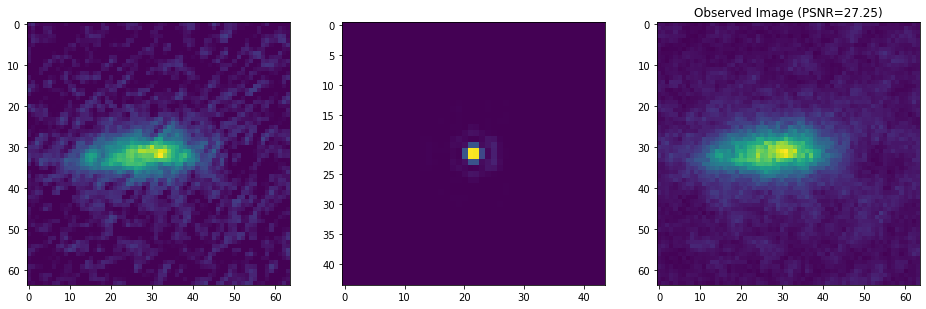

In [6]:
# Plot Image
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(gal_image)

plt.subplot(1,3,2)
plt.imshow(psf[10:-10,10:-10])

plt.subplot(1,3,3)
plt.imshow(obs)
plt.title('Observed Image (PSNR={:.2f})'.format(PSNR(gal_image, obs)))

# plt.subplot(1,3,4)
# plt.imshow(fourier_div)
# plt.title('Fourier Division (PSNR={:.2f})'.format(PSNR(gal_image, fourier_div)))

plt.show()

In [ ]:
print(gal_image.min(), gal_image.max(), gal_image.mean())
print(obs.min(), obs.max(), obs.mean())
print((gal_image<0).sum())